# Moons Dataset Explanation and Decision Tree Classification

This notebook explains the moons dataset, demonstrates how to use a Decision Tree to classify it, and details each step of the process.

## What is the Moons Dataset?

The moons dataset is a synthetic dataset generated by scikit-learn's `make_moons` function. It consists of two interleaving crescent-shaped clusters (like two moons), each representing a class. Each data point has two features (coordinates) and a label (0 or 1) indicating which moon it belongs to.

- **Purpose:** The dataset is designed to test classification algorithms, especially those that can handle non-linear boundaries.
- **Noise:** The `noise` parameter adds randomness, making the classification task more challenging and realistic.
- **Visualization:** The two classes are not linearly separable, so a straight line cannot perfectly separate them.

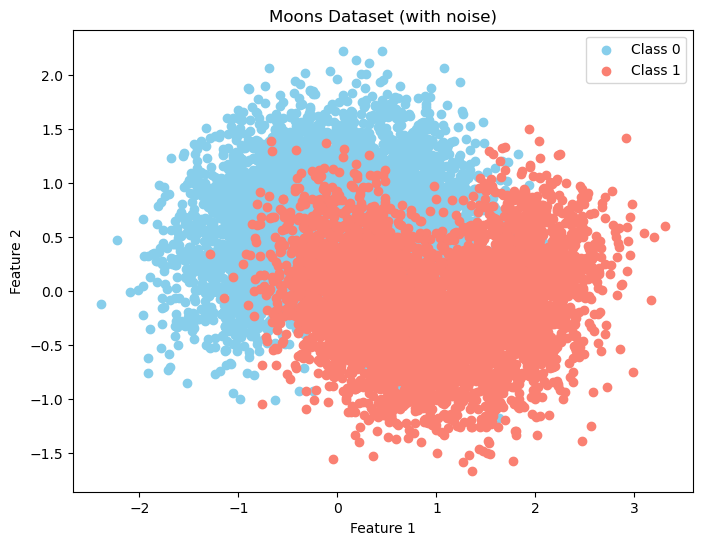

In [1]:
# Generate and visualize the moons dataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='skyblue', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='salmon', label='Class 1')
plt.title('Moons Dataset (with noise)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# 1. Train and Fine-tune a Decision Tree for the Moons Dataset

### a. Generate a moons dataset
We already generated the moons dataset above using `make_moons(n_samples=10000, noise=0.4, random_state=42)`. This gives us a large, noisy, two-class dataset.

### b. Split into training and test sets
We use `train_test_split()` to split the data into training and test sets (80%/20%). This ensures we can evaluate our model on unseen data.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 8000
Test set size: 2000


### c. Grid search for best hyperparameters
We use `GridSearchCV` to search for the best value of `max_leaf_nodes` for a `DecisionTreeClassifier`. This helps us find the optimal tree complexity for our data.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_leaf_nodes': list(range(2, 100))}
dt_clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
print(f'Best max_leaf_nodes: {best_leaf_nodes}')

Best max_leaf_nodes: 17


### d. Train on full training set and evaluate
We train a `DecisionTreeClassifier` with the best `max_leaf_nodes` on the full training set and evaluate its accuracy on the test set.

### 1d. Train on full training set and evaluate

After finding the best value for `max_leaf_nodes` using grid search, we train a new Decision Tree on the entire training set with this optimal value.

- **Training:** The tree is trained using all available training data, making use of the best-found complexity.
- **Prediction:** We use the trained tree to predict the labels of the test set (data the model has never seen).
- **Evaluation:** We calculate the accuracy, which is the proportion of correct predictions on the test set.

**Why is this important?**
- This step shows how well our model generalizes to new, unseen data.
- A high accuracy means our model has learned the underlying patterns without overfitting.
- This is a standard way to assess the real-world performance of a machine learning model.

In [4]:
from sklearn.metrics import accuracy_score

best_tree = DecisionTreeClassifier(max_leaf_nodes=best_leaf_nodes, random_state=42)
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of best Decision Tree: {accuracy:.4f}')

Accuracy of best Decision Tree: 0.8695


# 2. Grow a Forest (Ensemble of Decision Trees)

### a. Generate 1,000 subsets of the training set
We use `ShuffleSplit` to create 1,000 random subsets of 100 instances each from the training set. This simulates the bagging process used in ensemble methods.

In [5]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100
subsets = []
ss = ShuffleSplit(n_splits=n_trees, train_size=n_instances, random_state=42)
for train_idx, _ in ss.split(X_train):
    X_subset = X_train[train_idx]
    y_subset = y_train[train_idx]
    subsets.append((X_subset, y_subset))

### b. Train a Decision Tree on each subset
We train 1,000 `DecisionTreeClassifier`s (using the best `max_leaf_nodes`) on these subsets. Each tree is trained on a small, random sample of the data.

In [6]:
from sklearn.base import clone
import numpy as np

forest = []
for X_subset, y_subset in subsets:
    tree = DecisionTreeClassifier(max_leaf_nodes=best_leaf_nodes, random_state=42)
    tree.fit(X_subset, y_subset)
    forest.append(tree)

# Evaluate accuracy of each tree
all_preds = np.array([tree.predict(X_test) for tree in forest])
individual_accuracies = np.mean(all_preds == y_test, axis=1)
print(f'Average accuracy of individual trees: {np.mean(individual_accuracies):.4f}')

Average accuracy of individual trees: 0.8055


### c. Majority-vote predictions
For each test instance, we collect predictions from all 1,000 trees and use `scipy.stats.mode()` to select the most frequent prediction (majority vote). This is the essence of ensemble learning.

In [7]:
from scipy.stats import mode

majority_votes, _ = mode(all_preds, axis=0, keepdims=False)
ensemble_predictions = majority_votes
print(f'First 10 ensemble predictions: {ensemble_predictions[:10]}')

First 10 ensemble predictions: [1 1 0 0 0 1 1 1 1 0]


### d. Evaluate ensemble predictions
We calculate the accuracy of the majority-vote ensemble on the test set. The ensemble accuracy should be slightly higher than the best single tree (by about 0.5% to 1.5%).

In [8]:
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print(f'Ensemble accuracy: {ensemble_accuracy:.4f}')

Ensemble accuracy: 0.8720


# Summary
- The moons dataset is a classic example for testing non-linear classifiers.
- Decision Trees can be tuned for better performance using grid search.
- Bagging (ensemble of trees) improves accuracy by reducing variance.
- The ensemble method (majority vote) outperforms a single tree, demonstrating the power of ensemble learning.